# **Week 6: Lab Exercises for COMP499/691 Conversational AI**

The goal of this lab is to further familiarize yourself with SpeechBrain.
In the previous labs, you had to properly complete some "prefilled" code that implemented some speechbrain model. In this lab, instead, you will do a little step ahead and write a full training recipe from scratch.

## **Task Description**

This time we will work on speaker identification. The task is very simple: you have a speech signal in input, and you have to tell which of the N speakers in the pool is speaking.

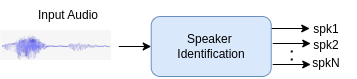

This problem is a supervised classification task, which is conceptually very similar to the audio digit classification already addressed in Lab 2 (the difference is that now we have speaker identities instead of digits in the output).

We will work on a small portion of the TIMIT dataset that contains 26 different speakers.


**Run the code below** to download and unzip the dataset.

In [1]:
%%capture
!wget -O TIMIT_tiny.zip  https://www.dropbox.com/scl/fi/7t7fi0t4cv424p7zem46g/TIMIT_tiny.zip?rlkey=efh571iyya5sb7w1kvk2xfi9h&dl=0

**Run the code below** to unzip the dataset.

In [2]:
%%capture
!unzip /content/TIMIT_tiny.zip -d data

**Run the code below to install speechbrain**.

In [3]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

## **Exercise 1: Data Preparation**

If you inspect the data stored in `/content/data` you will see 26 folders. Each folder contains the audio signals recorded for a single speaker. You can see different types of files in each folder. For this lab, you only need to consider the ".wav" ones. The name of each file (e.g., `si475.wav`) is a sentence identifier (`si475`). Each signal is sampled at 16 kHz.

**Write the code for preparing the JSON data-manifest files**. You have to split the dataset into train, validation, and test sets. Always use the sentence 'sa1.wav' (available for each speaker) for validation. Use the sentence 'sa2.wav' (available for each speaker) for testing. Use all the other sentences for training.

You have to create 3 JSON files:
- 'train.json'
- 'valid.json'
- 'test.json'

They should be formatted in the following way:


**train.json**
```
{
  "mpgl0_si469": {
    "path": "data/mpgl0/si469.wav",
    "length": 2.88,
    "spk": "mpgl0"
  },
  "mpgl0_si1729": {
    "path": "data/mpgl0/si1729.wav",
    "length": 3.5904375,
    "spk": "mpgl0"
  },
  "mpgl0_si1099": {
    "path": "data/mpgl0/si1099.wav",
    "length": 2.86725,
    "spk": "mpgl0"
  },
....

```

**valid.json**
```
{
  "mpgl0_sa1": {
    "path": "data/mpgl0/sa1.wav",
    "length": 3.6288125,
    "spk": "mpgl0"
  },
  "mtmr0_sa1": {
    "path": "data/mtmr0/sa1.wav",
    "length": 3.18725,
    "spk": "mtmr0"
  },
  "mwvw0_sa1": {
    "path": "data/mwvw0/sa1.wav",
    "length": 3.161625,
    "spk": "mwvw0"
  },
....
```

**test.json**

```
{
  "mpgl0_sa2": {
    "path": "data/mpgl0/sa2.wav",
    "length": 3.02725,
    "spk": "mpgl0"
  },
  "mtmr0_sa2": {
    "path": "data/mtmr0/sa2.wav",
    "length": 2.624,
    "spk": "mtmr0"
  },
  "mwvw0_sa2": {
    "path": "data/mwvw0/sa2.wav",
    "length": 2.5088125,
    "spk": "mwvw0"
  },

```

If everything is fine, you should have 208 files for training, 26 for validation, and 26 for testing.

**Suggestions:**
- Use the get_all_files in speechbrain.utils.data_utils to get a list of all the files with the wav extension.
- You can get the number of samples of each wave with torchaudio.info. You have to compute the duration in seconds by diving it for the sampling frequency.

**Your code here:**

In [4]:
%cd /content/

/content


In [5]:
import json
import os
import torchaudio
from speechbrain.utils.data_utils import get_all_files

# Your code here
# train_data = get_all_files("/content/data", exclude_and=['sa1.wav', 'sa2.wav'], match_and=['.wav'])


def create_json(data, dir_name):
  extracted_data = {}

  for file_path in data:
    spk = file_path.split('/')[1]
    sa_number = file_path.split('/')[-1].split('.')[0]
    info = torchaudio.info(file_path)

    # Compute duration in seconds
    duration_sec = info.num_frames / info.sample_rate

    # Construct dictionary entry
    key = f"{spk}_{sa_number}"
    extracted_data[key] = {
        "wav": file_path,
        "length": duration_sec,
        "spk": spk
    }

  # Write extracted data to a JSON file
  with open(f"{dir_name}.json", "w") as json_file:
      json.dump(extracted_data, json_file, indent=4)

train_data = get_all_files("data", match_and=['.wav'])
train_data = [file for file in train_data if os.path.basename(file) not in ['sa1.wav', 'sa2.wav']]

test_data = get_all_files("data", match_and=['sa2.wav'])

valid_data = get_all_files("data", match_and=['sa1.wav'])

print("Train Data -> ", len(train_data))
print("Test Data -> ", len(test_data))
print("Valid Data -> ", len(valid_data))

create_json(train_data, "train")
create_json(test_data, "test")
create_json(valid_data, "valid")

Train Data ->  208
Test Data ->  26
Valid Data ->  26


## **Exercise 2: Speaker Identification with FBANKs and Xvectors**

You have to implement the following model:



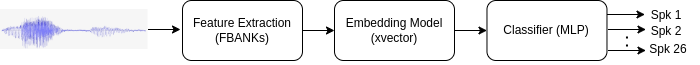

**Suggestion:** You can copy-and-paste the code from the previous labs solving similar classification problems. You only need to do the little modifications to the hyperparameter and train.py files needed to implement the system in the figure.

**Write the code for the hyperparameters**:

In [6]:
%%file hparams_xvector_fbanks.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/TIMIT_tiny/Xvector/FBanks/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 20
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 26
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size digits gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 3
    tdnn_channels: [128, 128, 128]
    tdnn_kernel_sizes: [5, 3, 1]
    tdnn_dilations: [1, 3, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Writing hparams_xvector_fbanks.yaml


**Write the code for the training script**:

In [7]:
%%file train.py

# Your code here

#!/usr/bin/env python3
"Recipe for training a spk classification system."
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


# Brain class for speech enhancement training
class DigitBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        batch = batch.to(self.device)
        wavs, lens = batch.sig
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)
        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch['sig']
        digit_encoded = batch["digit_encoded"].data

        loss = sb.nnet.losses.nll_loss(predictions, digit_encoded, lens)
        self.loss_metric.append(
            batch.id, predictions, digit_encoded, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, digit_encoded, lens)
        return loss

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()
    print(label_encoder)

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        sig, fs = torchaudio.load(wav)

        # Resampling
        sig = torchaudio.functional.resample(sig, fs, 16000).squeeze(0)
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("spk")
    @sb.utils.data_pipeline.provides("spk", "digit_encoded")
    def label_pipeline(spk):
        """Defines the pipeline to process the spk labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield spk
        digit_encoded = label_encoder.encode_label_torch(spk)
        yield digit_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "digit_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="spk",
    )

    return datasets


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    # Initialize the Brain object to prepare for mask training.
    digit_brain = DigitBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    digit_brain.fit(
        epoch_counter=digit_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = digit_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )

Writing train.py


**Run the code below to train your model.**

In [8]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf /content/results/TIMIT_tiny/Xvector/FBANKs/1986

# Run Training
!python train.py hparams_xvector_fbanks.yaml --device='cpu'

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./results/TIMIT_tiny/Xvector/FBanks/1986
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 145.6k trainable parameters in DigitBrain
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
100% 13/13 [00:04<00:00,  2.70it/s, train_loss=2.69]
100% 2/2 [00:00<00:00,  6.59it/s]
speechbrain.nnet.schedulers - Changing lr from 0.001 to 0.00095
speechbrain.utils.train_logger - Epoch: 1, lr: 1.00e-03 - train loss: 2.69 - valid loss: 3.20, valid error: 9.23e-01
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/TIMIT_tiny/Xvector/FBanks/1986/save/CKPT+2024-02-23+21-45-33+00
speechbrain.utils.epoch_loop -

You have to tweak the hyperparameter (e.g., batch size, learning rate) a bit to improve the performance. Do at least 20 epochs, If everything goes well, you should see a training curve similar to this one:


```
Epoch: 1, lr: 1.00e-03 - train loss: 2.82 - valid loss: 3.25, valid error: 9.62e-01
Epoch: 2, lr: 9.53e-04 - train loss: 1.92 - valid loss: 2.90, valid error: 9.62e-01
Epoch: 3, lr: 9.05e-04 - train loss: 1.39 - valid loss: 1.83, valid error: 3.46e-01
Epoch: 4, lr: 8.58e-04 - train loss: 9.68e-01 - valid loss: 1.50, valid error: 4.62e-01
Epoch: 5, lr: 8.11e-04 - train loss: 6.71e-01 - valid loss: 9.79e-01, valid error: 7.69e-02
Epoch: 6, lr: 7.63e-04 - train loss: 5.14e-01 - valid loss: 9.43e-01, valid error: 1.92e-01
Epoch: 7, lr: 7.16e-04 - train loss: 3.93e-01 - valid loss: 6.59e-01, valid error: 3.85e-02
Epoch: 8, lr: 6.68e-04 - train loss: 2.63e-01 - valid loss: 3.22e-01, valid error: 0.00e+00
Epoch: 9, lr: 6.21e-04 - train loss: 2.30e-01 - valid loss: 4.71e-01, valid error: 7.69e-02
Epoch: 10, lr: 5.74e-04 - train loss: 1.56e-01 - valid loss: 2.67e-01, valid error: 3.85e-02
Epoch: 11, lr: 5.26e-04 - train loss: 1.25e-01 - valid loss: 1.58e-01, valid error: 0.00e+00
Epoch: 12, lr: 4.79e-04 - train loss: 1.15e-01 - valid loss: 2.09e-01, valid error: 3.85e-02
Epoch: 13, lr: 4.32e-04 - train loss: 9.57e-02 - valid loss: 1.60e-01, valid error: 0.00e+00
Epoch: 14, lr: 3.84e-04 - train loss: 7.75e-02 - valid loss: 1.56e-01, valid error: 0.00e+00
Epoch: 15, lr: 3.37e-04 - train loss: 7.18e-02 - valid loss: 1.42e-01, valid error: 0.00e+00
Epoch: 16, lr: 2.89e-04 - train loss: 7.01e-02 - valid loss: 1.06e-01, valid error: 0.00e+00
Epoch: 17, lr: 2.42e-04 - train loss: 7.01e-02 - valid loss: 1.22e-01, valid error: 0.00e+00
Epoch: 18, lr: 1.95e-04 - train loss: 7.55e-02 - valid loss: 1.50e-01, valid error: 3.85e-02
Epoch: 19, lr: 1.47e-04 - train loss: 5.16e-02 - valid loss: 1.21e-01, valid error: 3.85e-02
Epoch: 20, lr: 1.00e-04 - train loss: 5.97e-02 - valid loss: 1.12e-01, valid error: 3.85e-02
Epoch loaded: 17 - test loss: 9.28e-02, test error: 0.00e+00

```

As you can see, you should be able to obtain a 0% error on both training and validation. If this is not the case, run the experiment again with a different set of hyperparameters. Note that we are using a tiny dataset and it is normal to see some significant performance variations after running the code multiple times with different random seeds.


It might be surprising to see a 0% error on both validation and test. On the other hand, for humans, it might be hard to detect which speaker is speaking among 26 candidates after listening for just a few minutes their voices. For a neural network, instead, this task is very easy. Even on large datasets containing noise recordings and thousands of speakers, a good neural network can identify speakers with 98-99% accuracy.




## **Exercise 3: Speaker Identification with MFCCs and Xvectors**

in this exercise, you have to run the same system as exercise 2, but with different speech features in the input.

This time, you should feed the system with mel frequency cepstral coefficients (MFCCs). You have to compute them with `speechbrain.lobes.features.MFCC` (please take a look at the documentation [here](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html). For this exercise, do not augment the features with the context and with the delta coefficients. You can compute 20 MFFCs.

Modify the hparam file to implement the MFCC-based speaker identification system. Note that you do not need to modify the train.py script as well.

**Your code here**:

In [11]:
%%file hparams_xvector_mfccs.yaml

# Your code here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/TIMIT_tiny/Xvector/MFCCs/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 20
batch_size: 16
lr_start: 0.001
lr_final: 0.0001
n_classes: 26
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>
    deltas: False
    context: False

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size digits gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 3
    tdnn_channels: [128, 128, 128]
    tdnn_kernel_sizes: [5, 3, 1]
    tdnn_dilations: [1, 3, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Overwriting hparams_xvector_mfccs.yaml


**Run the code below to train your model.**

In [12]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf ./results/TIMIT_tiny/Xvector/MFCCs/1986

# Run Training
!python train.py hparams_xvector_mfccs.yaml --device='cpu'

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./results/TIMIT_tiny/Xvector/MFCCs/1986
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - Gradscaler enabled: False. Using precision: fp32.
speechbrain.core - 145.6k trainable parameters in DigitBrain
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
100% 13/13 [00:03<00:00,  3.64it/s, train_loss=2.69]
100% 2/2 [00:00<00:00,  7.73it/s]
speechbrain.nnet.schedulers - Changing lr from 0.001 to 0.00095
speechbrain.utils.train_logger - Epoch: 1, lr: 1.00e-03 - train loss: 2.69 - valid loss: 3.20, valid error: 9.23e-01
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/TIMIT_tiny/Xvector/MFCCs/1986/save/CKPT+2024-02-23+21-48-56+00
speechbrain.utils.epoch_loop - G

If everything goes well, you should see a training curve simular to this one:


```
Epoch: 1, lr: 1.00e-03 - train loss: 2.69 - valid loss: 3.27, valid error: 9.62e-01
Epoch: 2, lr: 9.53e-04 - train loss: 1.60 - valid loss: 2.96, valid error: 7.69e-01
Epoch: 3, lr: 9.05e-04 - train loss: 1.04 - valid loss: 1.87, valid error: 4.62e-01
Epoch: 4, lr: 8.58e-04 - train loss: 6.46e-01 - valid loss: 1.29, valid error: 2.69e-01
Epoch: 5, lr: 8.11e-04 - train loss: 4.28e-01 - valid loss: 9.86e-01, valid error: 1.92e-01
Epoch: 6, lr: 7.63e-04 - train loss: 2.76e-01 - valid loss: 9.31e-01, valid error: 1.15e-01
Epoch: 7, lr: 7.16e-04 - train loss: 2.25e-01 - valid loss: 6.23e-01, valid error: 3.85e-02
Epoch: 8, lr: 6.68e-04 - train loss: 1.44e-01 - valid loss: 5.75e-01, valid error: 3.85e-02
Epoch: 9, lr: 6.21e-04 - train loss: 1.20e-01 - valid loss: 5.11e-01, valid error: 7.69e-02
Epoch: 10, lr: 5.74e-04 - train loss: 8.41e-02 - valid loss: 5.21e-01, valid error: 7.69e-02
Epoch: 11, lr: 5.26e-04 - train loss: 8.04e-02 - valid loss: 4.65e-01, valid error: 7.69e-02
Epoch: 12, lr: 4.79e-04 - train loss: 7.08e-02 - valid loss: 4.61e-01, valid error: 3.85e-02
Epoch: 13, lr: 4.32e-04 - train loss: 6.04e-02 - valid loss: 4.41e-01, valid error: 3.85e-02
Epoch: 14, lr: 3.84e-04 - train loss: 5.07e-02 - valid loss: 3.96e-01, valid error: 3.85e-02
Epoch: 15, lr: 3.37e-04 - train loss: 4.85e-02 - valid loss: 3.79e-01, valid error: 3.85e-02
Epoch: 16, lr: 2.89e-04 - train loss: 4.94e-02 - valid loss: 3.59e-01, valid error: 0.00e+00
Epoch: 17, lr: 2.42e-04 - train loss: 5.20e-02 - valid loss: 3.59e-01, valid error: 3.85e-02
Epoch: 18, lr: 1.95e-04 - train loss: 5.23e-02 - valid loss: 3.65e-01, valid error: 3.85e-02
Epoch: 19, lr: 1.47e-04 - train loss: 3.54e-02 - valid loss: 3.59e-01, valid error: 3.85e-02
Epoch: 20, lr: 1.00e-04 - train loss: 4.22e-02 - valid loss: 3.48e-01, valid error: 3.85e-02
Epoch loaded: 16 - test loss: 1.55e-01, test error: 0.00e+00
```

You should reach a perfect classification on both training and validation sets in this case as well.


That's all!
